In [32]:
import diplib as dip
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

In [33]:
def measurement_pipeline(filename, background_se_size, line_se_size, integrate_dim, units_between_peaks,
                         peak_distance = None, rot_deg = 0):
    # Load original image
    image = dip.ImageRead(filename)
    print("Original image:")
    print(image)
    image.Show()

    # Convert to greyscale if it is not already
    if image.TensorElements() > 1:
        gray_image = dip.ColorSpaceManager.Convert(image, "gray")
        print("Converted to grayscale:")
        print(gray_image)
        gray_image.Show()

        image = gray_image

    # Apply cosing with large SE to estimate background illumination
    se = dip.SE(background_se_size, "elliptic")
    image_bg = dip.Closing(image, se)
    print("Estimated background illumination:")
    image_bg.Show()

    # Subtract background illumination from originali image (moving the values back to positive integers)
    # aka Black-Hat transformation
    image_clean = image - image_bg
    image_clean -= dip.Minimum(image_clean)
    print("Subtract background illumination from original (Black-Hat transformation)")
    image_clean.Show()

    # Apply segmentation on the cleaned image
    image_seg = dip.IsodataThreshold(image_clean)
    print("Segmentation on the cleaned image:")
    image_seg.Show()

    # Rotate image to align reticule
    if rot_deg != 0:
        image_seg = dip.Rotation2D(image_seg, angle=np.deg2rad(rot_deg))
        print("Rotate image to align reticle:")
        image_seg.Show()

    # Perform closing using a line SE to remove opposite lines
    line_se = dip.SE(line_se_size, "rectangular")
    image_lines = dip.Closing(image_seg, line_se)
    print("Closing using line SE:")
    image_lines.Show()

    # Integrate over the rows or columns
    np_lines = np.array(image_lines)
    np_lines_count = np_lines.sum(axis=integrate_dim)
    plt.plot(np_lines_count)

    # Find the minima over the columns to detect line position
    peaks, _ = find_peaks(-np_lines_count, distance=peak_distance)
    plt.plot(peaks, np_lines_count[peaks], 'x')

    print("Peak positions when integrating over image rows or columns:")
    plt.show()

    # Calculate distance between peaks
    peak_distance = peaks[1:] - peaks[:-1]
    print(f"Distance between peaks: {peak_distance}")

    def reject_outliers(data, m=1):
        return data[abs(data - np.mean(data)) < m * np.std(data)]

    # Remove outliers in peak distances
    filtered_peak_distance = reject_outliers(peak_distance)
    print(f"Removing outliers: {filtered_peak_distance}")

    # Calculate mean peak distance
    mean_peak_distance = filtered_peak_distance.mean()
    print(f"Mean peak distance: {mean_peak_distance}")

    # Calculate units-per pixel size
    units_per_pixel = units_between_peaks / mean_peak_distance
    print(f"Units-per pixel size: {units_per_pixel}")

    return mean_peak_distance, units_per_pixel

# Part 3.1

=== Part 3.1.3: Pixel sizes ===
Original image:
2D Scalar image:
    data type:      UINT8
    sizes:          {2584, 1936}
    pixel size:     0.169333 mm x 0.169333 mm
    strides:        {1, 2584}, tensor stride 1
    data pointer:   0x61132679e340 (shared among 1 images)
    origin pointer: 0x61132679e340



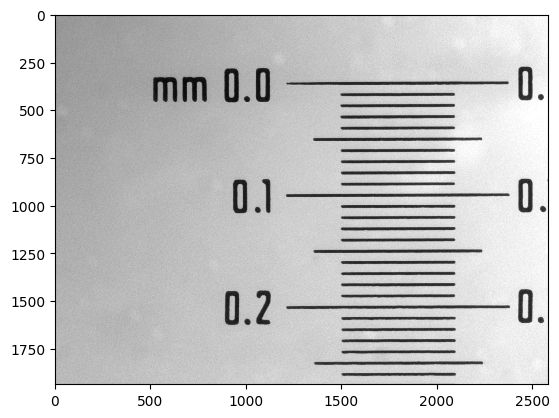

Estimated background illumination:


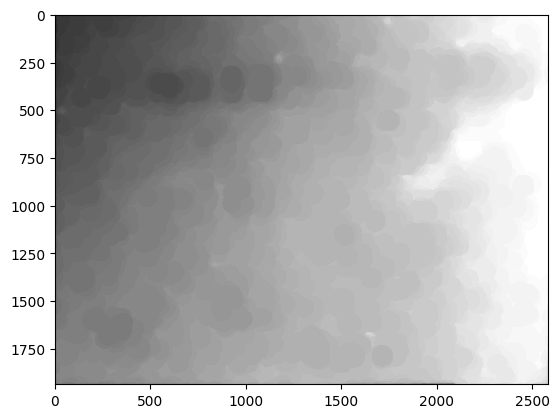

Subtract background illumination from original (Black-Hat transformation)


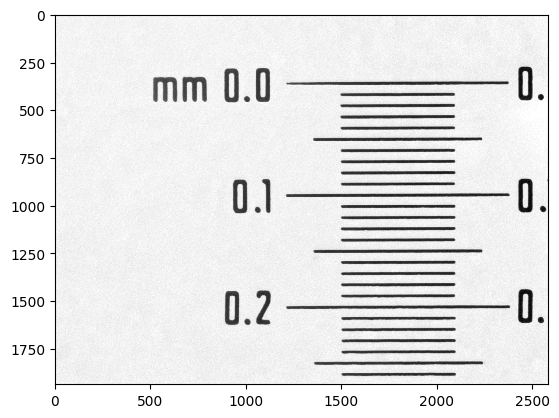

Segmentation on the cleaned image:


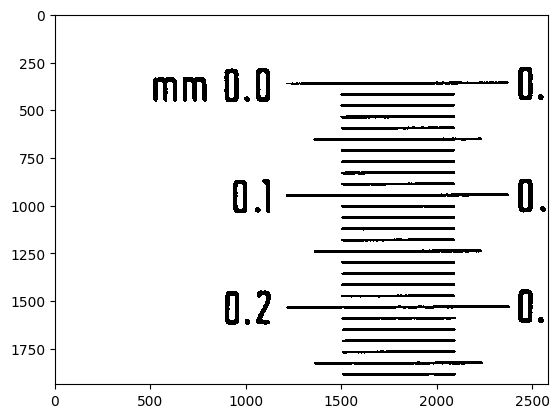

Closing using line SE:


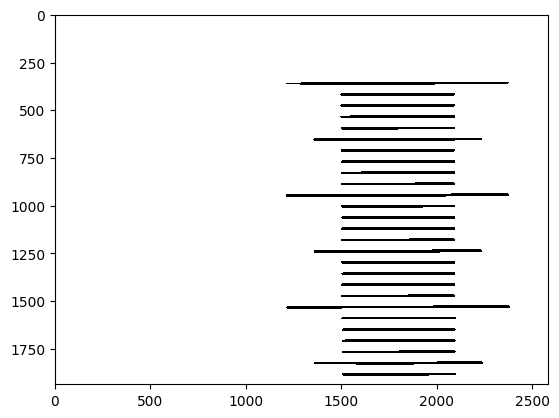

Peak positions when integrating over image rows or columns:


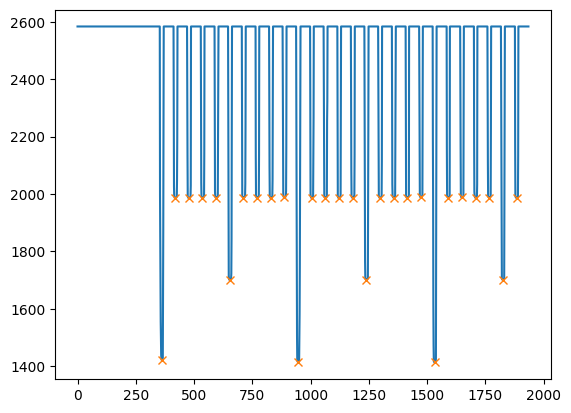

Distance between peaks: [58 58 58 59 59 57 60 58 59 59 59 58 59 59 58 59 58 57 60 59 58 60 57 59
 59 58]
Removing outliers: [58 58 58 59 59 58 59 59 59 58 59 59 58 59 58 59 58 59 59 58]
Mean peak distance: 58.55
Units-per pixel size: 17.079419299743808
Original image:
2D Scalar image:
    data type:      UINT8
    sizes:          {2584, 1936}
    pixel size:     0.169333 mm x 0.169333 mm
    strides:        {1, 2584}, tensor stride 1
    data pointer:   0x6113236977b0 (shared among 1 images)
    origin pointer: 0x6113236977b0



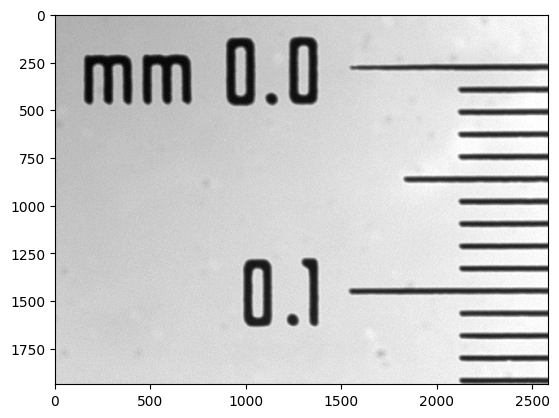

Estimated background illumination:


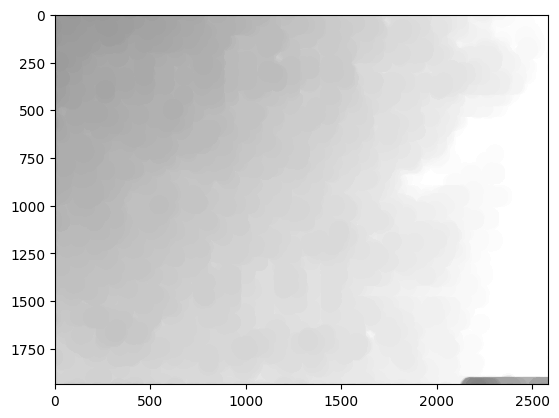

Subtract background illumination from original (Black-Hat transformation)


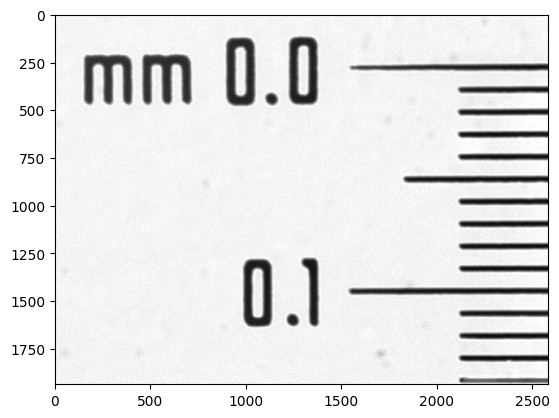

Segmentation on the cleaned image:


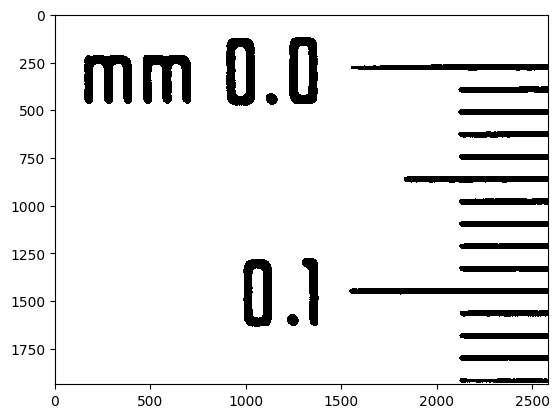

Closing using line SE:


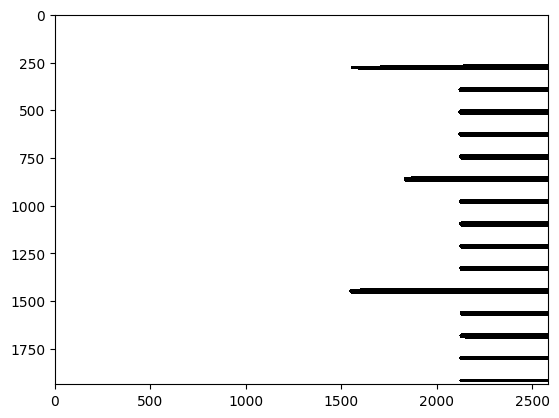

Peak positions when integrating over image rows or columns:


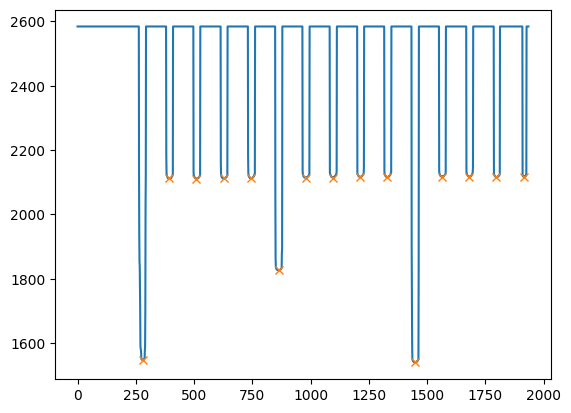

Distance between peaks: [113 116 117 119 118 116 116 118 114 120 116 117 116 120]
Removing outliers: [116 117 118 116 116 118 116 117 116]
Mean peak distance: 116.66666666666667
Units-per pixel size: 8.571428571428571
Original image:
2D Scalar image:
    data type:      UINT8
    sizes:          {2584, 1936}
    pixel size:     0.169333 mm x 0.169333 mm
    strides:        {1, 2584}, tensor stride 1
    data pointer:   0x6113226fee70 (shared among 1 images)
    origin pointer: 0x6113226fee70



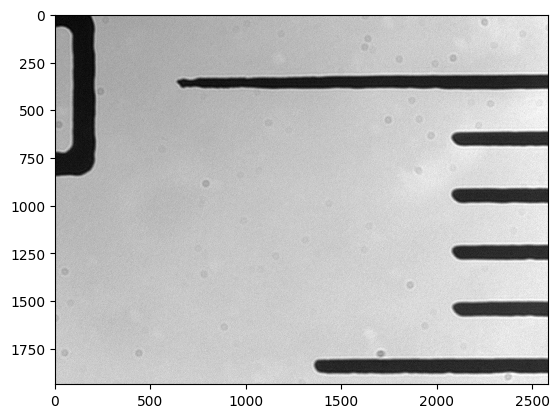

Estimated background illumination:


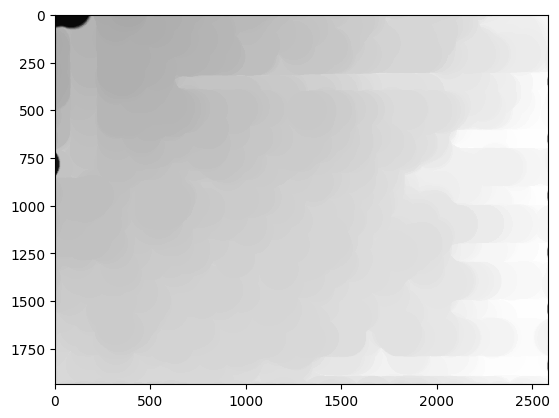

Subtract background illumination from original (Black-Hat transformation)


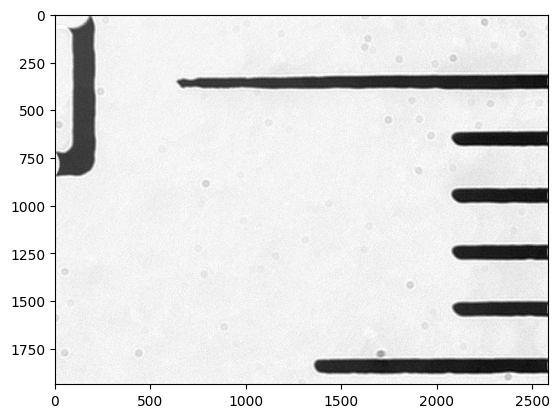

Segmentation on the cleaned image:


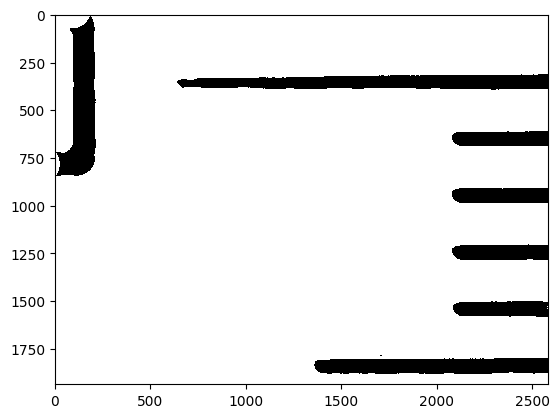

Closing using line SE:


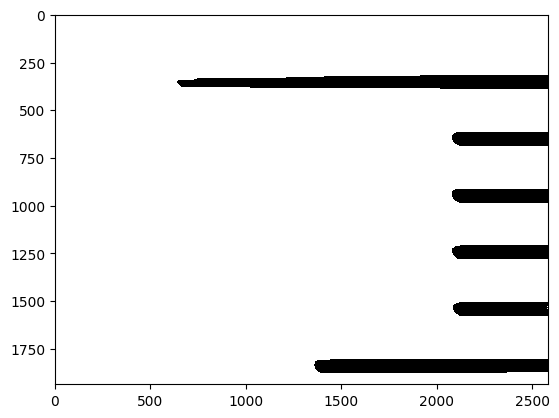

Peak positions when integrating over image rows or columns:


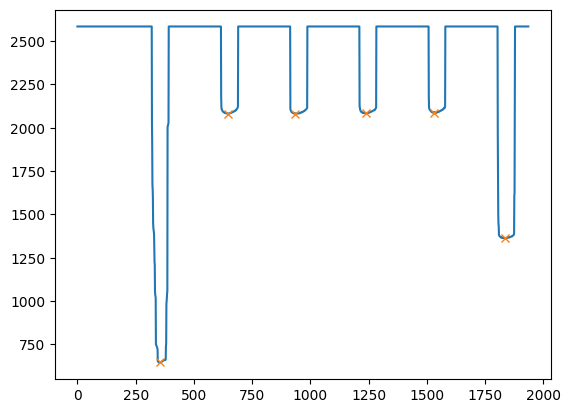

Distance between peaks: [293 288 305 293 301]
Removing outliers: [293 293 301]
Mean peak distance: 295.6666666666667
Units-per pixel size: 3.3821871476888385

Image	Pixels(bar)	µm/px
CamIm01.tif	58.55		17.0794
CamIm02.tif	116.67		8.5714
CamIm03.tif	295.67		3.3822

=== Part 3.1.4: Derived magnifications ===
Image	Computed mag (×)
CamIm01.tif	19.8×
CamIm02.tif	39.5×
CamIm03.tif	100.0×


In [ ]:
# -------------------------------------------------------------------
# Part 3.1 calls (3.1.1–3.1.4)
# -------------------------------------------------------------------
REAL_BAR_MM = 1
files = [
    ("CamIm01.tif", dict(background_se_size=100, line_se_size=(200,1))),
    ("CamIm02.tif", dict(background_se_size=100, line_se_size=(400,1))),
    ("CamIm03.tif", dict(background_se_size=200, line_se_size=(400,1), peak_distance=100)),
]

# 3.1.3: assemble table of pixel‐counts and pixel‐sizes
print("=== Part 3.1.3: Pixel sizes ===")
results = {}
for name, params in files:
    path = os.path.join("2025Assignment03Images", name)
    px, upx = measurement_pipeline(
        path,
        integrate_dim=1,
        units_between_peaks=REAL_BAR_MM,
        **params
    )
    results[name] = (px, upx)

print("\nImage\tPixels(bar)\tµm/px")
for name, (px, upx) in results.items():
    print(f"{name}\t{px:.2f}\t\t{upx:.4f}")

# 3.1.4: derive magnifications relative to the 100× ref (CamIm03.tif)
print("\n=== Part 3.1.4: Derived magnifications ===")
ref_px, ref_upx = results["CamIm03.tif"]
print("Image\tComputed mag (×)")
for name, (px, upx) in results.items():
    mag = (ref_upx / upx) * 100.0
    print(f"{name}\t{mag:.1f}×")

# Part 3.2

In [35]:
# -------------------------------------------------------------------
# Part 3.2 calls (3.2.5–3.2.6)
# -------------------------------------------------------------------

tif_path = os.path.join("2025Assignment03Images", "scale-img.tif")
ics_path = os.path.join("2025Assignment03Images", "scale-img.ics")
ids_path = os.path.join("2025Assignment03Images", "scale-img.ids")

# 3.2.5: dump and inspect the ICS header
print("\n=== Part 3.2.5: ICS header ===")
with open(ics_path, "r") as f:
    for line in f:
        print(line.rstrip())

# 3.2.6: compare TIFF vs ICS image content and file-sizes
print("\n=== Part 3.2.6: Numeric comparison TIFF vs ICS ===")
img_tif = dip.ImageReadTIFF(tif_path)
img_ics = dip.ImageReadICS(ics_path)  # requires both .ics and .ids in same folder

arr_tif = np.array(img_tif)
arr_ics = np.array(img_ics)

diff = np.abs(arr_tif.astype(float) - arr_ics.astype(float))
print(f"Mean abs difference: {diff.mean():.4f}")
print(f"Std  abs difference: {diff.std():.4f}")
print(f"Max  abs difference: {diff.max():.4f}")

size_tif = os.path.getsize(tif_path)
size_ics_total = os.path.getsize(ics_path) + os.path.getsize(ids_path)
print(f"File size TIFF      : {size_tif} bytes")
print(f"File size ICS + IDS : {size_ics_total} bytes")


=== Part 3.2.5: ICS header ===

ics_version	1.0
filename	scale-img
layout	parameters	3
layout	order	bits	x	y
layout	sizes	32	256	256
layout	coordinates	video
layout	significant_bits	32
representation	format	real
representation	sign	signed
representation	byte_order	4	3	2	1
representation	SCIL_TYPE	f2d

=== Part 3.2.6: Numeric comparison TIFF vs ICS ===
Mean abs difference: 0.0000
Std  abs difference: 0.0000
Max  abs difference: 0.0000
File size TIFF      : 65769 bytes
File size ICS + IDS : 262416 bytes


# Part 3.3

=== Part 3.3.7-3.3.8: Pixel sizes ===
Original image:
2D Scalar image:
    data type:      SFLOAT
    sizes:          {256, 256}
    strides:        {1, 256}, tensor stride 1
    data pointer:   0x611323258ce0 (shared among 1 images)
    origin pointer: 0x611323258ce0



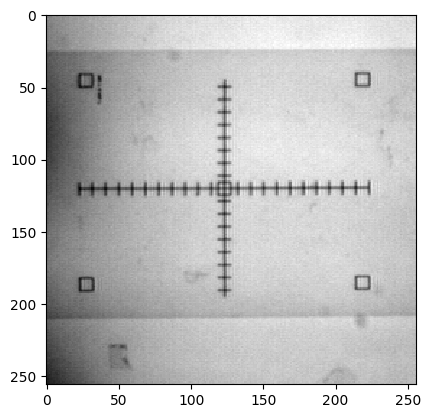

Estimated background illumination:


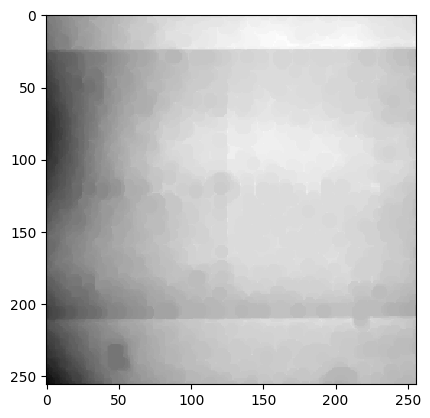

Subtract background illumination from original (Black-Hat transformation)


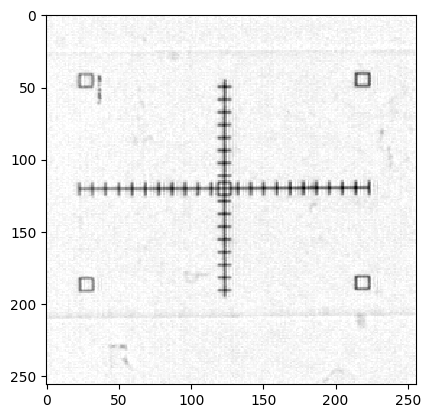

Segmentation on the cleaned image:


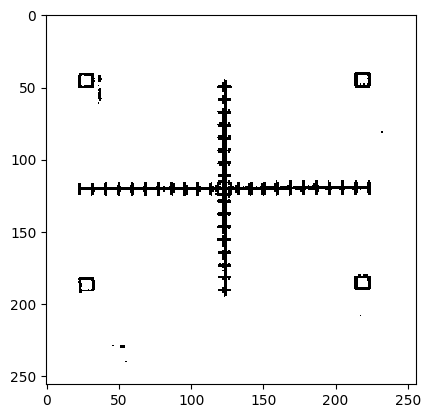

Closing using line SE:


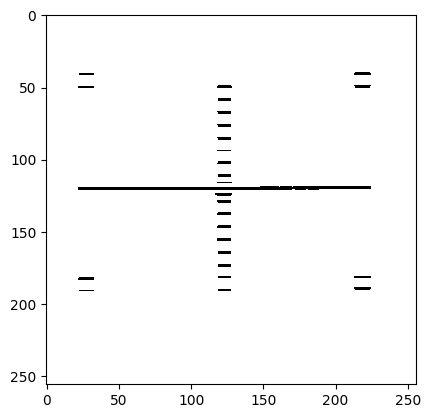

Peak positions when integrating over image rows or columns:


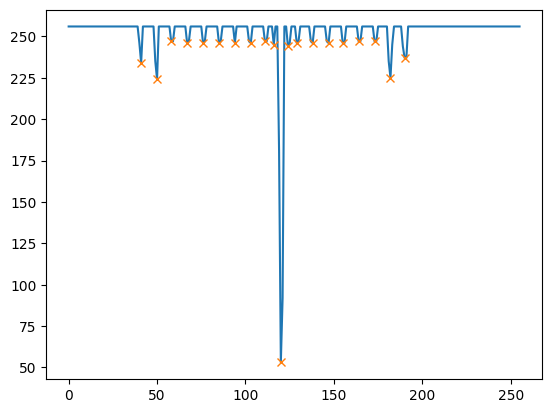

Distance between peaks: [9 8 9 9 9 9 9 8 5 4 4 5 9 9 8 9 9 9 8]
Removing outliers: [9 8 9 9 9 9 9 8 9 9 8 9 9 9 8]
Mean peak distance: 8.733333333333333
Units-per pixel size: 0.11450381679389314

Image	Pixels(bar)	units/px
scale-img.ics	8.73		0.1145


In [36]:
# -------------------------------------------------------------------
# Part 3.3 calls (3.3.7–3.3.8)
# -------------------------------------------------------------------
REAL_BAR_UNIT_SIZE = 1
name = "scale-img.ics"
path = os.path.join("2025Assignment03Images", name)

# 3.3.7-3.3.8: derive pixel size
print("=== Part 3.3.7-3.3.8: Pixel sizes ===")
px, upx = measurement_pipeline(
    path,
    background_se_size=10,
    line_se_size=(8,1),
    integrate_dim=1,
    units_between_peaks=REAL_BAR_UNIT_SIZE,
)

print("\nImage\tPixels(bar)\tunits/px")
print(f"{name}\t{px:.2f}\t\t{upx:.4f}")

# Part 3.4

=== Part 3.3.7-3.3.8: Pixel sizes ===
Original image:
2D Color image (3x1 column vector, 3 elements, sRGB):
    data type:      UINT8
    sizes:          {1292, 968}
    pixel size:     0.169333 mm x 0.169333 mm
    strides:        {3, 3876}, tensor stride 1
    data pointer:   0x611321149620 (shared among 1 images)
    origin pointer: 0x611321149620



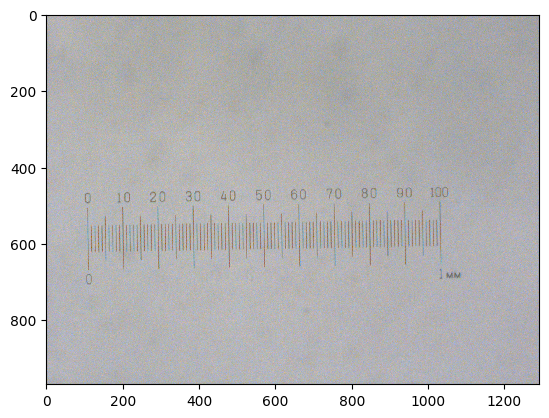

Converted to grayscale:
2D Scalar image:
    data type:      SFLOAT
    sizes:          {1292, 968}
    pixel size:     0.169333 mm x 0.169333 mm
    strides:        {1, 1292}, tensor stride 1
    data pointer:   0x6113236977b0 (shared among 1 images)
    origin pointer: 0x6113236977b0



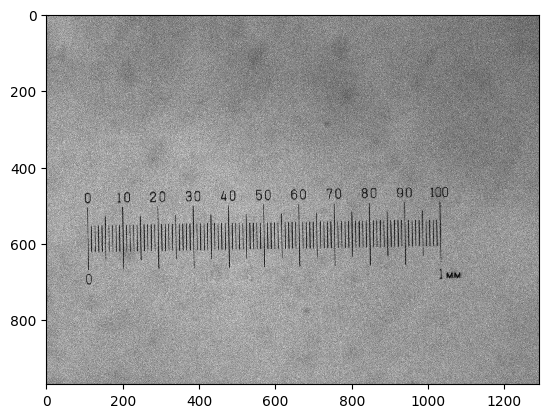

Estimated background illumination:


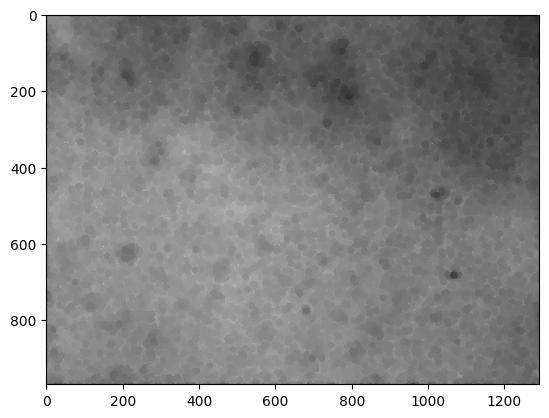

Subtract background illumination from original (Black-Hat transformation)


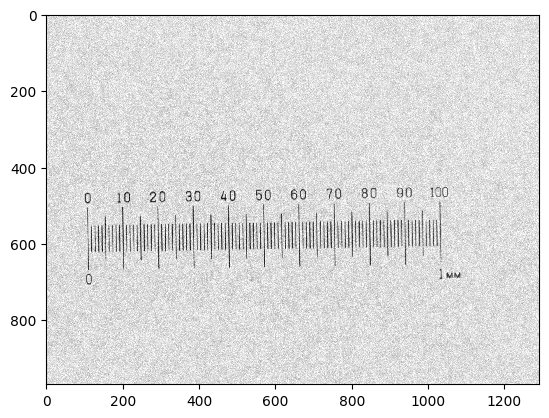

Segmentation on the cleaned image:


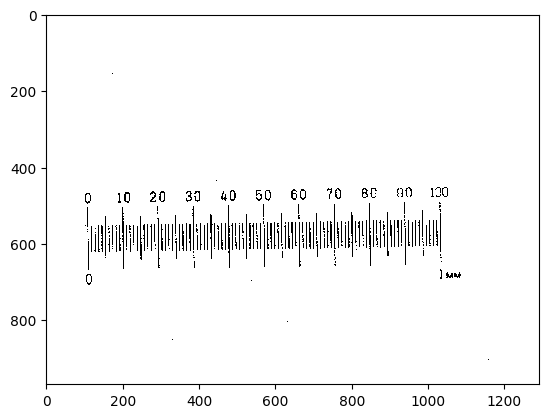

Rotate image to align reticle:


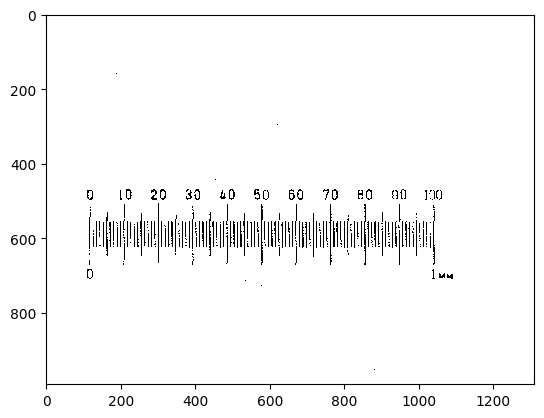

Closing using line SE:


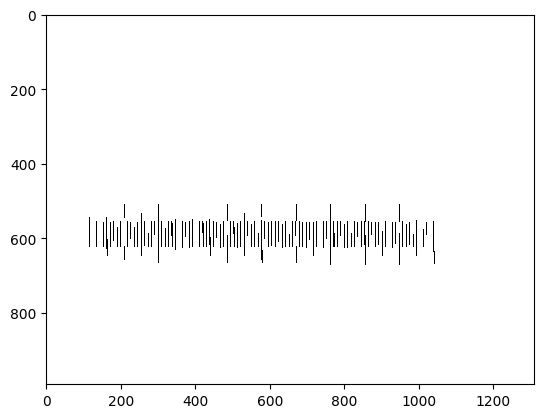

Peak positions when integrating over image rows or columns:


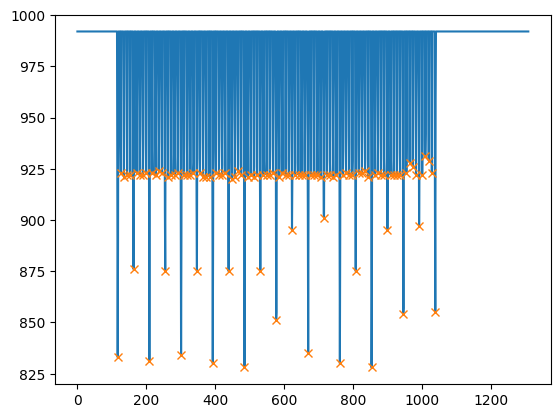

Distance between peaks: [ 9  9  9  9 10  9  9  9  9 10  9  9  9  9 10  9  9  9  9 10  9  9  9  9
 10  9  9  9 10  9  9  9  9  9 10  9  9  9  9 10  9  9  9  9 10  9  9 10
  9  9  9  9 10  9  9  9 10  9  9 10  9  9  9  9 10  8 10  9  9 10  9  9
  9  9 10  9  9  9 10  9  9  9  9 10  9  9  9 10  9  9  9 10  9  9  9  9
  9 10  9 10]
Removing outliers: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9]
Mean peak distance: 9.0
Units-per pixel size: 0.1111111111111111

Image	Pixels(bar)	mm/px
CamIm04.tif	9.00		0.1111

=== Part 3.3.8: Derived magnification ===
Image	Computed mag (×)
CamIm04.tif	3.0×


In [37]:
# -------------------------------------------------------------------
# Part 3.4 calls (3.4.9–3.4.10)
# -------------------------------------------------------------------
REAL_BAR_MM = 1
name = "CamIm04.tif"
path = os.path.join("2025Assignment03Images", name)

# 3.3.7-3.3.8: derive pixel size
print("=== Part 3.3.7-3.3.8: Pixel sizes ===")
px, upx = measurement_pipeline(
    path,
    background_se_size=15,
    line_se_size=(1,32),
    integrate_dim=0,
    units_between_peaks=REAL_BAR_MM,
    rot_deg=1
)

print("\nImage\tPixels(bar)\tmm/px")
print(f"{name}\t{px:.2f}\t\t{upx:.4f}")

# 3.3.8: derive magnification relative to the 100× ref (CamIm03.tif)
print("\n=== Part 3.3.8: Derived magnification ===")
ref_px, ref_upx = results["CamIm03.tif"]
print("Image\tComputed mag (×)")
adjusted_upx = upx * 1000 # Conversion mm/px to µm/px
mag = (ref_upx / adjusted_upx) * 100
print(f"{name}\t{mag:.1f}×")
